# **TikTok Project**

# **Build a logistic regression model**

**The goal** is to build a logistic regression model that predicts verified status and evaluate the model.
<br/>

*This activity has three parts:*

**Part 1:** Data Preprocessing & Checking Model Assumptions

**Part 2:** Model Building and Evaluation

**Part 3:** Interpreting Model Results


### **Imports and loading**

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

### **Data Preprocessing**

**Note:**

From our previous phases we know:
- data has some missing values
- data has no duplicates
- Skewed data distribution Video view and like counts are all concentrated on low end of 1,000 for  opinions. Therefore, the data distribution is  right-skewed so we will need to handle those outliers
- Approximately 94.2% of the dataset represents videos posted by unverified accounts and 5.8% represents videos posted by verified accounts. So the outcome variable is not very balanced. so we will use resampling to create class balance in the outcome variable

In [3]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


### Missing values

In [4]:
# Drop rows with missing values
data = data.dropna(axis=0)

### Outliers

**Note:** We know from our previous phases that our features have alot of outliers, Keeping in mind that many of the features will not be used to fit our model, the most important columns to check for outliers are likely to be:
* `video_duration_sec`
* `video_view_count`
* `video_like_count`
* `video_comment_count`

Let's recap how there boxplots looked like

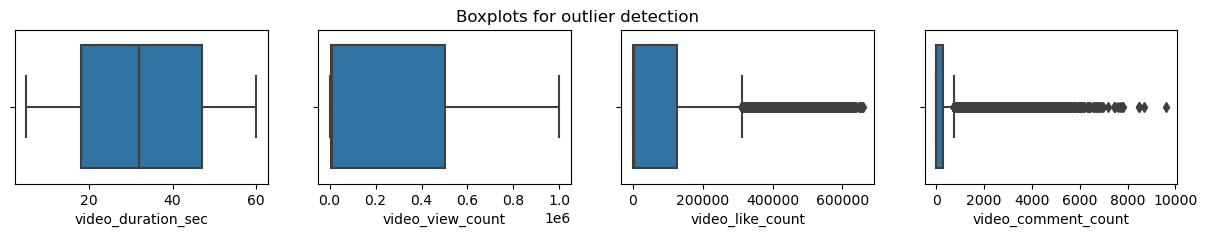

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=data['video_duration_sec'])
sns.boxplot(ax=axes[1], x=data['video_view_count'])
sns.boxplot(ax=axes[2], x=data['video_like_count'])
sns.boxplot(ax=axes[3], x=data['video_comment_count'])
plt.show();

In [6]:
def handle_outliers(data, col):
    """
        Handles outliers for specific column

        Args:
            data (pd.Dataframe): The dataset.
            col (pd.Series): the column containing outliers

        Returns:
            df: dataframe without outliers in given column.
    """

    # Get 1st and 3rd quarter    
    percentile25 = data[col].quantile(0.25)
    percentile75 = data[col].quantile(0.75)

    # Calculate IQR`
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr

    # Remove outliers
    data.loc[data[col] > upper_limit, col] = upper_limit

    return data

In [7]:
# handle outliers for `video_like_count`
data = handle_outliers(data, "video_like_count")

# handle outliers for `video_comment_count`
data = handle_outliers(data, "video_comment_count")


### Resampling

Since we know that the outcome variable is not very balanced. so we will use resampling to create class balance in the outcome variable

In [8]:
# Use resampling to create class balance in the outcome variable, if needed

# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 
                                 n_samples=len(data_majority), 
                                 random_state=0)               

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

### Feature engineering

In [9]:
# Get the average `video_transcription_text` length for claims and the average `video_transcription_text` length for opinions
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


we will extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [10]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(func=lambda text: len(text))

In [11]:
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Lets visualize the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts.

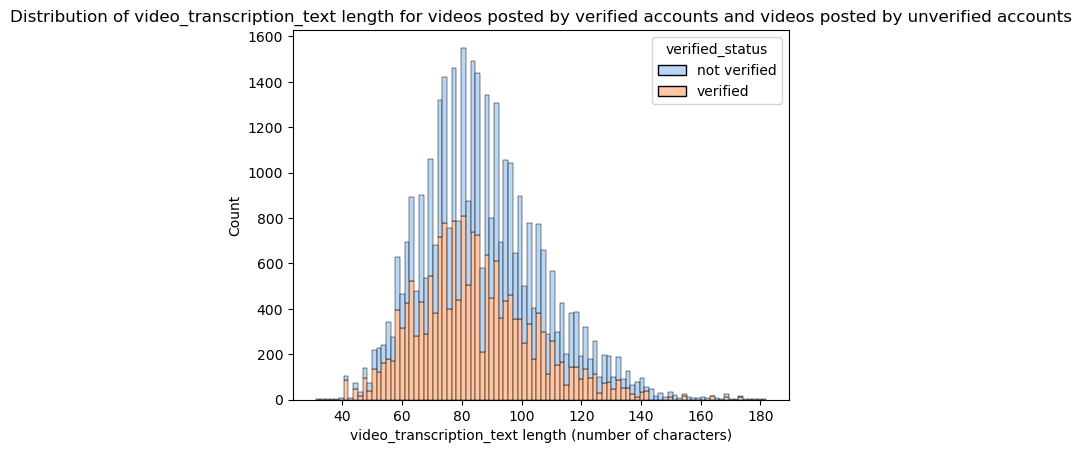

In [12]:
sns.histplot(data=data_upsampled, stat="count", multiple="stack", x="text_length", kde=False, palette="pastel", 
             hue="verified_status", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts")
plt.show()

### **Correlation analysis**

correlation heatmap of the data.

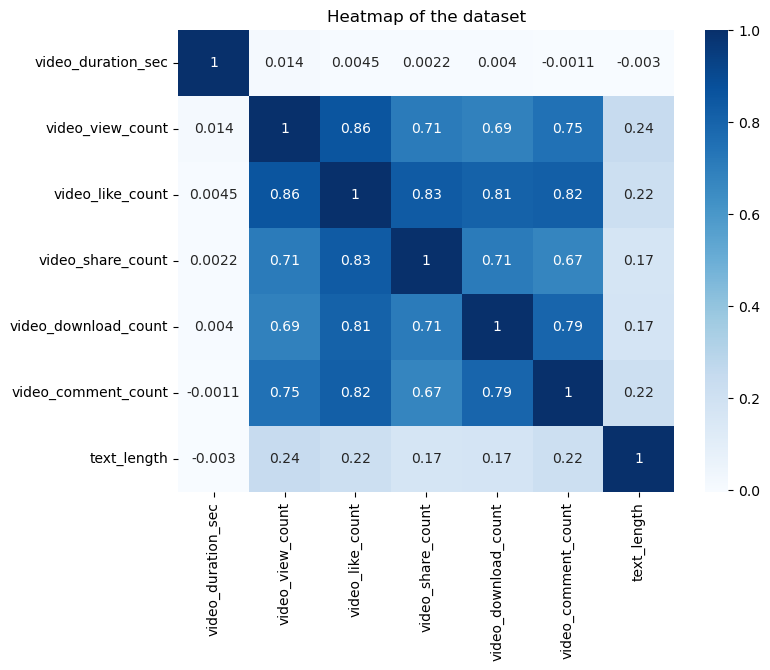

In [13]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]]
    .corr(numeric_only=True), 
    annot=True, 
    cmap="Blues")
plt.title("Heatmap of the dataset")
plt.show()

**Note:** The above heatmap shows that the following pair of variables are strongly correlated: `video_view_count` and `video_like_count` (0.86 correlation coefficient).

One of the model assumptions for logistic regression is no severe multicollinearity among the features. To build a logistic regression model that meets this assumption, we could exclude `video_like_count`. And among the variables that quantify video metrics, we could keep `video_view_count`, `video_share_count`, `video_download_count`, and `video_comment_count` as features.

### **Feature selection**

In [14]:
# Select features
X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count",
                    "video_share_count", "video_download_count", "video_comment_count"]]

# Select outcome variable
y = data_upsampled["verified_status"]

# Display first few rows of features dataframe
X.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
0,59,claim,under review,343296.0,241.0,1.0,0.0
1,32,claim,active,140877.0,19034.0,1161.0,684.0
2,31,claim,active,902185.0,2858.0,833.0,329.0
3,25,claim,active,437506.0,34812.0,1234.0,584.0
4,19,claim,active,56167.0,4110.0,547.0,152.0


### **Split data**

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [16]:
# Get shape of each training and testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

### **Feature Encoding**

Check the data types of the features.

In [17]:
# Check data types
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [18]:
# Get unique values in `claim_status`
X_train["claim_status"].unique()

array(['opinion', 'claim'], dtype=object)

In [19]:
# Get unique values in `author_ban_status`
X_train["author_ban_status"].unique()

array(['active', 'under review', 'banned'], dtype=object)

In [20]:
def preprocess(X, y):
    """
        puts the data in the right format for the model.

        Args:
            X (pd.Dataframe): data to preprocess.
            y (pd.Series): outcome variable to be preprocessed

        Returns: preprocessed X, y
    """
    # Select the training features that needs to be encoded
    X_train_to_encode = X[["claim_status", "author_ban_status"]]
    
    # Set up an encoder for one-hot encoding the categorical features
    X_encoder = OneHotEncoder(drop='first', sparse_output=False)
    
    # Fit and transform the training features using the encoder
    X_encoded = X_encoder.fit_transform(X_train_to_encode)

    # Place encoded training features (which is currently an array) into a dataframe
    X_encoded_df = pd.DataFrame(data=X_encoded, columns=X_encoder.get_feature_names_out())
    # Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
    X_final = pd.concat([X.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_encoded_df], axis=1)

    # Set up an encoder for one-hot encoding the categorical features
    y_encoder = OneHotEncoder(drop='first', sparse_output=False)

    # Encode the training outcome variable
    y_final = y_encoder.fit_transform(y.values.reshape(-1, 1)).ravel()
    
    return X_final, y_final
        

In [21]:
# Preprocess training data
X_train_final, y_train_final = preprocess(X_train, y_train)

### **Model building**

In [22]:
# Construct and fit model
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train_final, y_train_final)

### **Results and evaluation**

Evaluate your model.

In [23]:
# Preprocess testing data
X_test_final, y_test_final = preprocess(X_test, y_test)

In [24]:
# Display first few rows
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,728.5,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,728.5,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


Test the logistic regression model. Use the model to make predictions on the encoded testing set.

In [25]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred = log_clf.predict(X_test_final)

In [26]:
encoded_test = pd.get_dummies(y_test, drop_first=True).astype(int).squeeze()

# Display the actual & predictions on the encoded testing set
pd.DataFrame({"Actual": encoded_test, "Predicted": y_pred})

,Actual,Predicted
21061,1,1.0
31748,1,1.0
20197,1,0.0
5727,0,0.0
11607,0,1.0
...,...,...
14756,0,1.0
26564,1,1.0
14800,0,1.0
35705,1,0.0


### **Visualize model results**

Lets create a confusion matrix to visualize the results of the logistic regression model.

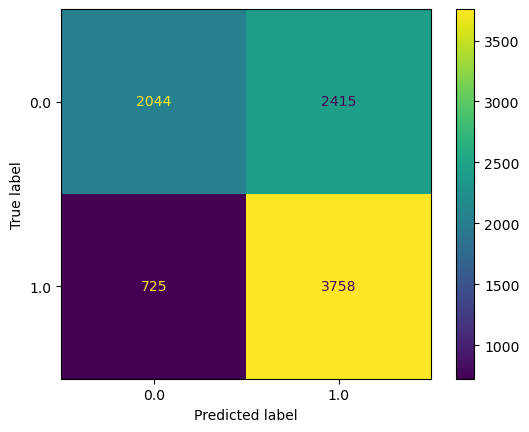

In [27]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

**Notes:**

The upper-left quadrant displays the number of true negatives: the number of videos posted by unverified accounts that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of videos posted by unverified accounts that the model misclassified as posted by verified accounts.

The lower-left quadrant displays the number of false negatives: the number of videos posted by verified accounts that the model misclassified as posted by unverified accounts.

The lower-right quadrant displays the number of true positives: the number of videos posted by verified accounts that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

Lets create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

In [28]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.46      0.57      4459
not verified       0.61      0.84      0.71      4483

    accuracy                           0.65      8942
   macro avg       0.67      0.65      0.64      8942
weighted avg       0.67      0.65      0.64      8942



**Note:** The classification report above shows that the logistic regression model achieved a precision of 61% and a recall of 84%, and it achieved an accuracy of 65%. Note that the precision and recall scores are taken from the "not verified" row of the output because that is the target class that we are most interested in predicting. The "verified" class has its own precision/recall metrics, and the weighted average represents the combined metrics for both classes of the target variable.

### **Interpret model coefficients**

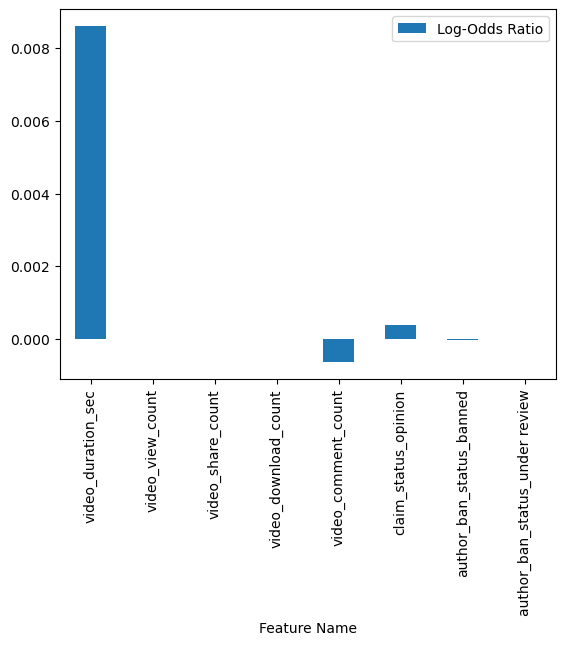

In [29]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
df_coef = pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Log-Odds Ratio":log_clf.coef_[0]})
df_coef.plot(kind='bar', x='Feature Name', y='Log-Odds Ratio');

### **Conclusion**

- The dataset has a few strongly correlated variables, which might lead to multicollinearity issues when fitting a logistic regression model. We decided to drop `video_like_count` from the model building.
- Based on the logistic regression model, each additional second of the video is associated with 0.009 increase in the log-odds of the user having a verified status.
- The logistic regression model had not great, but acceptable predictive power: a precision of 61% is less than ideal, but a recall of 84% is very good. Overall accuracy is towards the lower end of what would typically be considered acceptable. 


We developed a logistic regression model for verified status based on video features. The model had decent predictive power. Based on the estimated model coefficients from the logistic regression, **longer videos tend to be associated with higher odds of the user being verified**. Other video features have small estimated coefficients in the model, so their association with verified status seems to be small.

## Summary

Share an executive summary with my team [link](https://github.com/yousefayman2003/Portfolio-Projects/blob/main/Data-Science/TikTok/regression_analysis/executive_summary.pdf)